In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
train_ds = torchvision.datasets.MNIST('data',train=True,transform=transform,download=True)
dataloader = torch.utils.data.DataLoader(train_ds,batch_size = 128,shuffle = True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
            nn.Tanh()
        )
    def forward(self,x):
        img = self.main(x)
        return img.view(-1,28,28)
    
class Discrimeinator(nn.Module):
    def __init__(self):
        super(Discrimeinator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.main(x)
        return x

In [4]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

gen = Generator().to(device=device)
dis = Discrimeinator().to(device=device)

g_optim = torch.optim.Adam(gen.parameters(),lr=0.00005)
d_optim = torch.optim.Adam(dis.parameters(),lr=0.00005)

loss_fn = nn.BCELoss()

cuda


In [9]:
def gen_img_plot(model,test_input):
    pred = np.squeeze(model(test_input).detach().cpu().numpy())

    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((pred[i]+1)/2)
        plt.axis('off')
    plt.show()

In [6]:
test_input = torch.randn(16,100,device = device)

In [7]:
D_loss = []
G_loss = []
epoch = 1
epochs = 3

for epoch in range(epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    print('epoch:',epoch)
    for step ,(img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size,100).to(device=device)

        d_optim.zero_grad()
        real_output = dis(img)

        d_real_loss = loss_fn(real_output,torch.ones_like(real_output))
        d_real_loss.backward()

        gen_img = gen(random_noise)
        fake_output = dis(gen_img.detach())

        d_fake_loss = loss_fn(fake_output,torch.zeros_like(fake_output))
        d_fake_loss.backward()

        d_loss = d_real_loss + d_fake_loss
        d_optim.step()

        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,torch.ones_like(fake_output))
        g_loss.backward()
        g_optim.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss

    with torch.no_grad():
        d_epoch_loss /=count
        g_epoch_loss /=count

    D_loss.append(d_epoch_loss)
    G_loss.append(g_epoch_loss)




epoch: 0
epoch: 1
epoch: 2


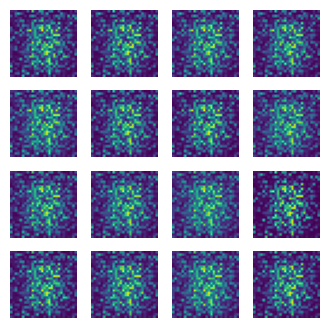

test_input.size(): torch.Size([16, 100])


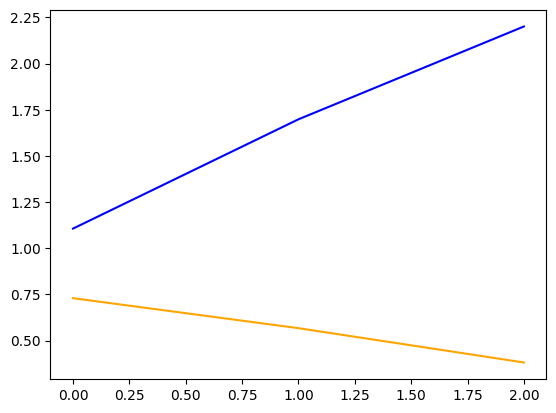

In [11]:
# 可视化
gen_img_plot(gen,test_input)
print('test_input.size():',test_input.size())
G_loss_cpu = [tensor.cpu().numpy() for tensor in G_loss]
D_loss_cpu = [tensor.cpu().numpy() for tensor in D_loss]

plt.plot(range(len(G_loss_cpu)),G_loss_cpu,color = 'blue',label='G_loss')
plt.plot(range(len(D_loss_cpu)),D_loss_cpu,color = 'orange',label='D_loss')
plt.show()